In [152]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date

import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
#import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys

def get_var_list(list_name):
    '''
    Get a list of variables associated with a pre-defined name.
    '''
    if list_name == 'ocn':
        var_list = ['sst','sss','uocn','vocn','frzmlt']
    elif list_name == 'atmo':
        var_list = ['Tair','uatm','vatm','fswdn','flwdn','snow']
    elif list_name == 'wave':
        var_list = ['aice','wave_sig_ht','peak_period','mean_wave_dir']
    elif list_name == 'ice':
        var_list = ['aice','hi','fsdrad','iage','uvel','vvel','frazil','congel']
    elif list_name == 'JRA55':
            var_list = ['airtmp']
    elif list_name == 'static':
#        var_list = ['aice','hi','hs','fsdrad','sice','iage','vlvl','vrdg']
        var_list = ['aice','hi','hs','fsdrad','iage','alvl']
    else:
        var_list = [list_name]

    return var_list

def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()
    
#del length

# Complete $k$-means clustering on sea ice velocities

In [153]:
np.array([100, 200, 300])

array([100, 200, 300])

In [216]:
netcdfpath = '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history'
files = sorted(glob.glob(netcdfpath + '/iceh.2019'+ '*.nc'))
indices = [0, 50, 100, 150, 200, 250, 301]
selected_files = ['/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-01-11.nc', 
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-01-30.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-02-12.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-03-11.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-04-20.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-05-19.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-06-23.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-08-04.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-09-23.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-10-15.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-11-26.nc',
                  '/Volumes/Elements/Gadi/ia40/cice-dirs/runs/waves-10/history/iceh.2019-12-27.nc',]
                  #[files[i] for i in indices]

desired_vars = ['aice', 'fsdrad', 'uvel', 'vvel', 'dafsd_wave', 'wave_sig_ht', 'fsdrad', 'hi', 'iage', 'HTE', 'HTN', 'tarea', 'TLAT', 'TLON']
 
# Open the dataset with Dask for lazy loading and preselect variables
#step = 15
ds_cice = xr.open_mfdataset(
    selected_files,#[0::step],  # List of file paths
    combine='by_coords',  # Method to combine datasets
    chunks={'time': 30},  # Example chunk size; adjust based on your data and memory
    data_vars='minimal',   # Load only the specified variables
    coords='minimal',      # Load only the specified coordinates
    #compat='override',
    preprocess=lambda ds: ds[desired_vars].where(ds['aice']>0.15) # .isel(nj=slice(0, 324)) #lambda ds: ds[desired_vars]  # Select only the desired variables
)
ds_cice

<xarray.Dataset>
Dimensions:      (time: 12, nj: 181, ni: 360, nf: 12)
Coordinates:
    TLAT         (nj, ni) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    TLON         (nj, ni) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    NFSD         (nf) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    ULAT         (nj, ni) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    ULON         (nj, ni) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
  * time         (time) datetime64[ns] 2019-01-12 2019-01-31 ... 2019-12-28
Dimensions without coordinates: nj, ni, nf
Data variables:
    aice         (time, nj, ni) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    uvel         (time, nj, ni) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    vvel         (time, nj, ni) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    dafsd_wave   (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 181, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hi           (time, nj, ni) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    iage         (time, nj, ni) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    HTE          (nj, ni, time) float32 dask.array<chunksize=(181, 360, 1), meta=np.ndarray>
    HTN          (nj, ni, time) float32 dask.array<chunksize=(181, 360, 1), meta=np.ndarray>
    tarea        (nj, ni, time) float32 dask.array<chunksize=(181, 360, 1), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model, CICE_6.2.0
    comment:      This year has 365 days
    comment2:     File written on model date 20190112
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      Fri Dec 15 14:54:15 2023: ncks -d nj,0,180 -O /g/data/ia40/...
    io_flavor:    io_netcdf
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...

In [221]:
df = ds_cice.to_dataframe()
df = df.dropna()[['uvel', 'vvel', 'hi', 'aice', 'fsdrad', 'TLAT', 'TLON']]
df

uvel      vvel        hi      aice      fsdrad  \
time       nj ni  nf                                                       
2019-01-12 1  232 0   0.000097  0.000491  3.233504  0.987624  849.450256   
                  1   0.000097  0.000491  3.233504  0.987624  849.450256   
                  2   0.000097  0.000491  3.233504  0.987624  849.450256   
                  3   0.000097  0.000491  3.233504  0.987624  849.450256   
                  4   0.000097  0.000491  3.233504  0.987624  849.450256   
...                        ...       ...       ...       ...         ...   
2019-12-28 45 278 7   0.388748  0.070420  0.282713  0.163328    2.688746   
                  8   0.388748  0.070420  0.282713  0.163328    2.688746   
                  9   0.388748  0.070420  0.282713  0.163328    2.688746   
                  10  0.388748  0.070420  0.282713  0.163328    2.688746   
                  11  0.388748  0.070420  0.282713  0.163328    2.688746   

                           TLAT   TLON  
time       nj ni  nf                    
2019-01-12 1  232 0  -77.629898  312.5  
                  1  -77.629898  312.5  
                  2  -77.629898  312.5  
                  3  -77.629898  312.5  
                  4  -77.629898  312.5  
...                         ...    ...  
2019-12-28 45 278 7  -58.493172  358.5  
                  8  -58.493172  358.5  
                  9  -58.493172  358.5  
                  10 -58.493172  358.5  
                  11 -58.493172  358.5  

[796512 rows x 7 columns]

/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value

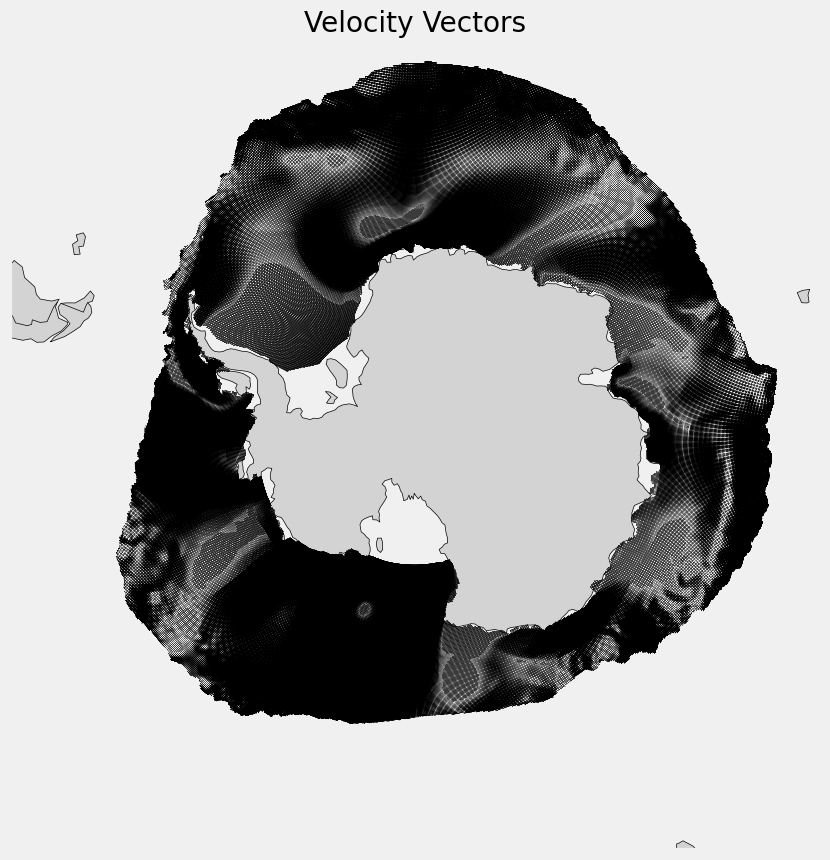

In [174]:
specific_time = '2012-09-08'
selected_data = df.loc[specific_time]
selected_data

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the quiver (velocity vectors)
ax.quiver(selected_data['TLON'], selected_data['TLAT'], selected_data['uvel'], selected_data['vvel'], transform=ccrs.PlateCarree(), scale=100, width=0.0005)

# Set the extent if you want to zoom into a particular region
ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())

plt.title('Velocity Vectors')
plt.show()

/var/folders/03/765pb_2s43v72wd74nscd38w0000gn/T/ipykernel_87672/3203370603.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['speed'] = np.sqrt(df['uvel']**2 + df['vvel']**2)


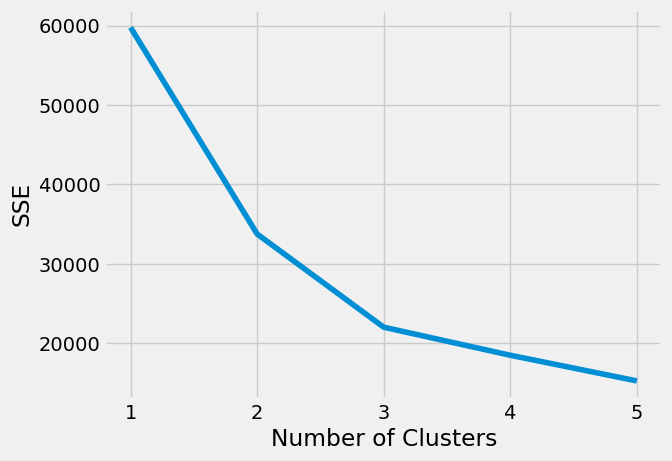

In [242]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

X_train = df[[ 'aice', 'hi']] #, 'aice', 'hi']]
#[['aice','hi','uvel','vvel','fsdrad']]
X_train['speed'] = np.sqrt(df['uvel']**2 + df['vvel']**2)

# Initialize the scaler
scaler = MinMaxScaler()  # You can also use MinMaxScaler() or others
scaled_data = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_data, columns=X_train.columns)

X_train
kmeans.fit(X_train)
kmeans.inertia_
kmeans.cluster_centers_
kmeans.n_iter_
kmeans.labels_[:6]


kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 6), sse)
plt.xticks(range(1, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [243]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=2020,)

kmeans.fit(X_train)

predicted = kmeans.predict(X_train) 
print(kmeans.cluster_centers_)

df_kmeans = df.copy()
df_kmeans['k'] = predicted
df_kmeans


[[0.3557945  0.099738   0.2079002 ]
 [0.9768617  0.15241037 0.3986495 ]
 [0.96009624 0.20639008 0.14113562]]


uvel      vvel        hi      aice      fsdrad  \
time       nj ni  nf                                                       
2019-01-12 1  232 0   0.000097  0.000491  3.233504  0.987624  849.450256   
                  1   0.000097  0.000491  3.233504  0.987624  849.450256   
                  2   0.000097  0.000491  3.233504  0.987624  849.450256   
                  3   0.000097  0.000491  3.233504  0.987624  849.450256   
                  4   0.000097  0.000491  3.233504  0.987624  849.450256   
...                        ...       ...       ...       ...         ...   
2019-12-28 45 278 7   0.388748  0.070420  0.282713  0.163328    2.688746   
                  8   0.388748  0.070420  0.282713  0.163328    2.688746   
                  9   0.388748  0.070420  0.282713  0.163328    2.688746   
                  10  0.388748  0.070420  0.282713  0.163328    2.688746   
                  11  0.388748  0.070420  0.282713  0.163328    2.688746   

                           TLAT   TLON  k  
time       nj ni  nf                       
2019-01-12 1  232 0  -77.629898  312.5  2  
                  1  -77.629898  312.5  2  
                  2  -77.629898  312.5  2  
                  3  -77.629898  312.5  2  
                  4  -77.629898  312.5  2  
...                         ...    ... ..  
2019-12-28 45 278 7  -58.493172  358.5  0  
                  8  -58.493172  358.5  0  
                  9  -58.493172  358.5  0  
                  10 -58.493172  358.5  0  
                  11 -58.493172  358.5  0  

[796512 rows x 8 columns]

In [223]:
df_kmeans

uvel      vvel        hi      aice      fsdrad  \
time       nj ni  nf                                                       
2019-01-12 1  232 0   0.000097  0.000491  3.233504  0.987624  849.450256   
                  1   0.000097  0.000491  3.233504  0.987624  849.450256   
                  2   0.000097  0.000491  3.233504  0.987624  849.450256   
                  3   0.000097  0.000491  3.233504  0.987624  849.450256   
                  4   0.000097  0.000491  3.233504  0.987624  849.450256   
...                        ...       ...       ...       ...         ...   
2019-12-28 45 278 7   0.388748  0.070420  0.282713  0.163328    2.688746   
                  8   0.388748  0.070420  0.282713  0.163328    2.688746   
                  9   0.388748  0.070420  0.282713  0.163328    2.688746   
                  10  0.388748  0.070420  0.282713  0.163328    2.688746   
                  11  0.388748  0.070420  0.282713  0.163328    2.688746   

                           TLAT   TLON  
time       nj ni  nf                    
2019-01-12 1  232 0  -77.629898  312.5  
                  1  -77.629898  312.5  
                  2  -77.629898  312.5  
                  3  -77.629898  312.5  
                  4  -77.629898  312.5  
...                         ...    ...  
2019-12-28 45 278 7  -58.493172  358.5  
                  8  -58.493172  358.5  
                  9  -58.493172  358.5  
                  10 -58.493172  358.5  
                  11 -58.493172  358.5  

[796512 rows x 7 columns]

In [239]:
df_kmeans_reset = df_kmeans.reset_index()
df_kmeans_reset['time'].unique()

array(['2019-01-12T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
       '2019-02-13T00:00:00.000000000', '2019-03-12T00:00:00.000000000',
       '2019-04-21T00:00:00.000000000', '2019-05-20T00:00:00.000000000',
       '2019-06-24T00:00:00.000000000', '2019-08-05T00:00:00.000000000',
       '2019-09-24T00:00:00.000000000', '2019-10-16T00:00:00.000000000',
       '2019-11-27T00:00:00.000000000', '2019-12-28T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [237]:
df_kmeans.head

<bound method NDFrame.head of                           uvel      vvel        hi      aice      fsdrad  \
time       nj ni  nf                                                       
2019-01-12 1  232 0   0.000097  0.000491  3.233504  0.987624  849.450256   
                  1   0.000097  0.000491  3.233504  0.987624  849.450256   
                  2   0.000097  0.000491  3.233504  0.987624  849.450256   
                  3   0.000097  0.000491  3.233504  0.987624  849.450256   
                  4   0.000097  0.000491  3.233504  0.987624  849.450256   
...                        ...       ...       ...       ...         ...   
2019-12-28 45 278 7   0.388748  0.070420  0.282713  0.163328    2.688746   
                  8   0.388748  0.070420  0.282713  0.163328    2.688746   
                  9   0.388748  0.070420  0.282713  0.163328    2.688746   
                  10  0.388748  0.070420  0.282713  0.163328    2.688746   
                  11  0.388748  0.070420  0.282713  0.1633

/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value

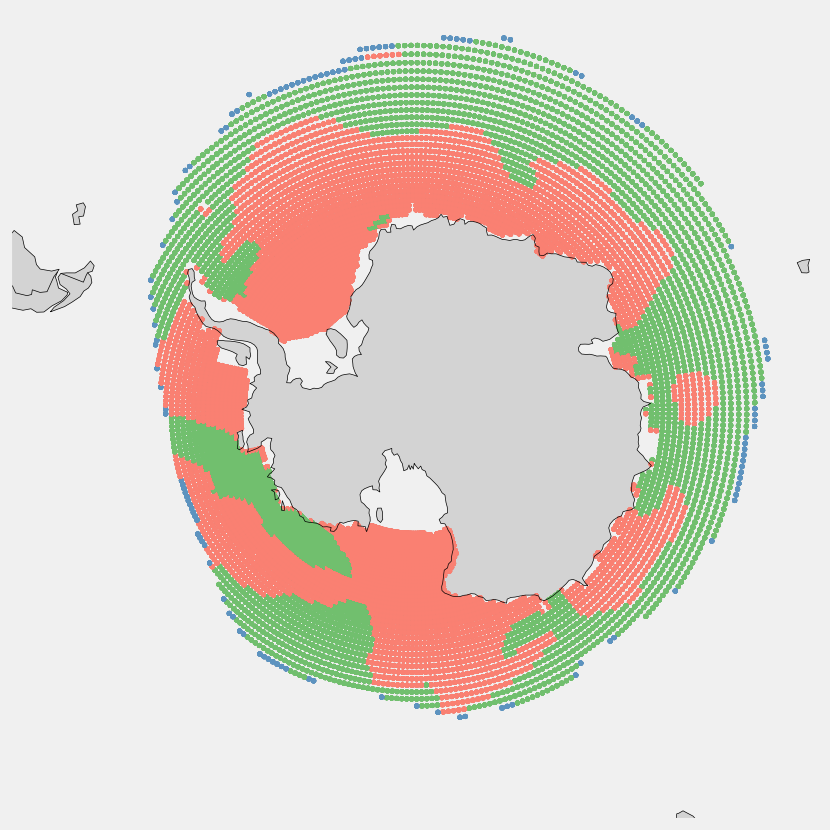

In [244]:
specific_time = '2019-09-24T00:00:00.000000000'
selected_data = df_kmeans.loc[specific_time]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

cmap = mpl.colors.ListedColormap([ (0.3639, 0.5755, 0.748, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.9805, 0.5000, 0.4453, 1.0)])

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

#ax.pcolormesh(df_kmeans['TLON'], df_kmeans['TLAT'], df_kmeans['k'], transform=ccrs.PlateCarree())
sc = ax.scatter(selected_data['TLON'], selected_data['TLAT'], c=selected_data['k'], cmap=cmap, s=10, transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
plt.savefig('figures/map-speed_1deg.png', dpi = 300) 
plt.show()

In [249]:
from scipy.interpolate import griddata

# Interpolate the data to the grid
grid_k = griddata((selected_data['TLON'], selected_data['TLAT']), selected_data['k'], (ds_cice['TLON'], ds_cice['TLAT']), method='conservative')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

cmap = mpl.colors.ListedColormap([(0.3639, 0.5755, 0.748, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.9805, 0.5000, 0.4453, 1.0)])

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot using pcolormesh
mesh = ax.pcolormesh(ds_cice['TLON'], ds_cice['TLAT'], grid_k, cmap=cmap, transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('k value')

plt.savefig('figures/map-speed_1deg.png', dpi=300)
plt.show()

ValueError: Unknown interpolation method 'conservative' for 2 dimensional data

In [258]:
import seaborn as sns
import scienceplots

year = 2019
COLOR_MIZ = [0.9805, 0.5000, 0.4453, 1.0]
COLOR_FSD = sns.color_palette("colorblind",15)[2]
COLOR_WAVE = sns.color_palette("colorblind",15)[3]
COLOR_IAGE = sns.color_palette("colorblind",15)[4]
COLOR_INTERIOR = sns.color_palette("colorblind",15)[0]

# Plot settings
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
textwidth = 3.31314*2
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

#plt.style.use("seaborn")
plt.style.use('default')
plt.style.use(['science','ieee', 'grid'])
sns.set_context("paper")
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
font_size = 14
mpl.rcParams.update({'font.size': font_size})
mpl.rcParams.update({"axes.grid" : True, "grid.color": [0.6, 0.6, 0.6]})
sns.color_palette("colorblind",15)


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/noahday/opt/anaconda3/envs/notebook/

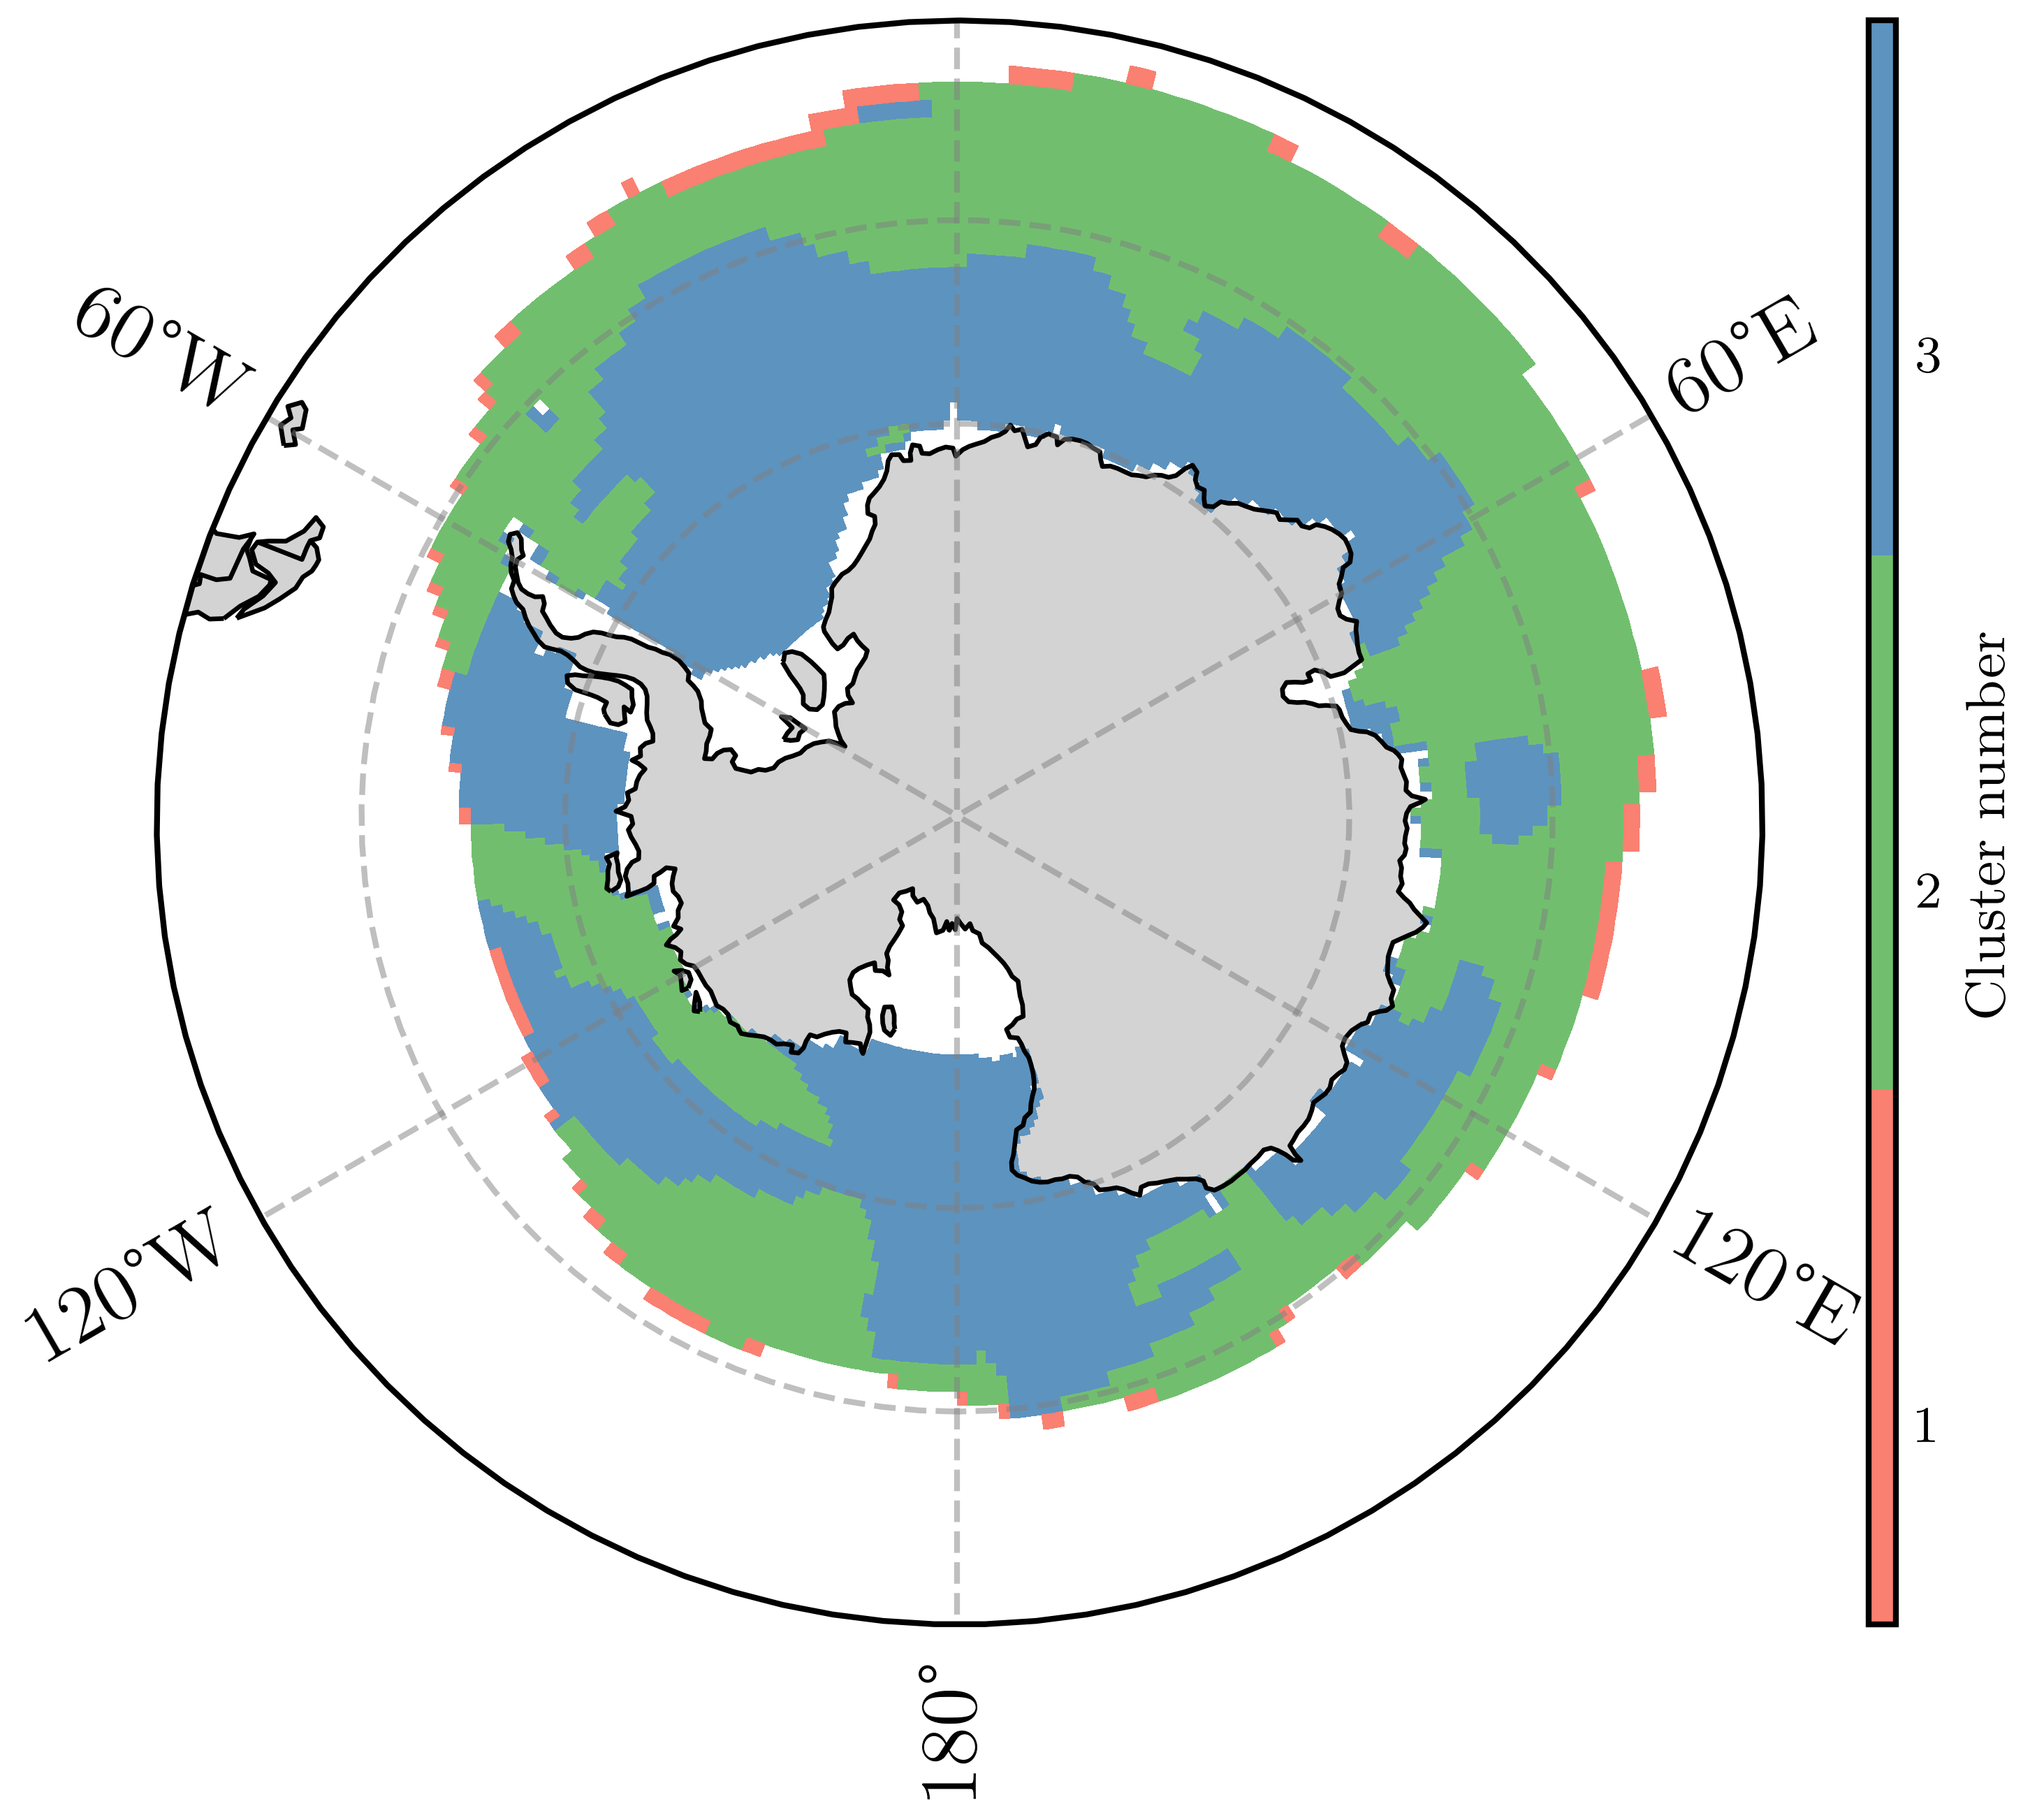

In [301]:
from scipy.spatial import cKDTree
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath


fig = plt.figure(figsize=[width, height])
ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,  x_inline=False, y_inline=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.botttom_labels = False
gl.left_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True

gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120])
gl.ylocator = mticker.FixedLocator([-70, -60])
#gl.set_extent((10, 90, 20, 90))
#ax1.set_yticks([-80, -70])
#gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {#'size': 15, 
                   'color': 'gray'}
gl.xlabel_style = {'color': 'black', 'weight': 'bold'}

#ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax2.add_feature(cfeature.LAND)


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax2.set_boundary(circle, transform=ax2.transAxes)
ax=ax2


# Define the grid
grid_lon = ds_cice['TLON'].values
grid_lat = ds_cice['TLAT'].values
#grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Flatten the grid coordinates
grid_points = np.c_[grid_lon.ravel(), grid_lat.ravel()]

# Create a KDTree for the grid points
tree = cKDTree(grid_points)

# Find the nearest grid point for each data point
distances, indices = tree.query(selected_data[['TLON', 'TLAT']].values)

# Create an array for the grid values
grid_k = np.full(grid_lon.shape, np.nan)

# Assign the values to the nearest grid points
for i, index in enumerate(indices):
    grid_k[np.unravel_index(index, grid_k.shape)] = selected_data['k'].values[i]

cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot using pcolormesh
cs = ax.pcolormesh(grid_lon, grid_lat, grid_k, cmap=cmap, transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())

# Add a colorbar
#cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
#cbar.set_label('Cluster number, $k$')

pos1 = ax.get_position()
fig.subplots_adjust(right=1-10/64) # (right=1-10/64)
cbar_ax = fig.add_axes([pos1.x0 + pos1.width + 0.01, pos1.y0, 0.01, pos1.height])
cbar = fig.colorbar(cs, cax=cbar_ax,orientation='vertical', label='Cluster number') 
bounds = np.linspace(1, 3, 4)

tick_labels = ['1', '2', '3',]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar.set_ticks(bounds[0:-1] - 0.75)
tick_texts = cbar.ax.set_yticklabels(tick_labels)


plt.savefig('figures/map-speed_1deg.png', dpi=300)
plt.show()

In [296]:
norm

In [294]:
bounds

array([0., 1., 2., 3.])

In [233]:
df_kmeans.loc['2019-08-04']

KeyError: '2019-08-04'